In [31]:
def resize_data(X_train, new_len):

    if new_len > X_train.shape[1]:
        print(f"new_len {new_len} is greater than the current length {X_train.shape[1]}, returning original dataset.")
        return X_train
    
    X_resized = X_train[:, :new_len]
    
    return X_resized

In [32]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# 讀取數據
train_normal = np.load('Data/train_normal.npy')
train_outer_break = np.load('Data/train_outer_break.npy')
train_inner_break = np.load('Data/train_inner_break.npy')

# 創建標籤
labels_normal = np.zeros(len(train_normal))
labels_outer_break = np.ones(len(train_outer_break))
labels_inner_break = np.full(len(train_inner_break), 2)

# 合併數據和標籤
X_train = np.concatenate((train_normal, train_outer_break, train_inner_break), axis=0)
X_train = resize_data(X_train, 1000)
y_train = np.concatenate((labels_normal, labels_outer_break, labels_inner_break), axis=0)
print(X_train.shape)
print(y_train.shape)

X_train_tensor = torch.tensor(X_train, dtype=torch.float).unsqueeze(1)  # Adding channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Assuming classification task

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 1  # Adjust the batch size according to your needs and hardware capabilities

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



(750, 1000)
(750,)


In [41]:
class VibrationCNN(nn.Module):
    def __init__(self):
        super(VibrationCNN, self).__init__()
        # Assuming 1D Convolutional layers for sequence data
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=1, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        # The size here might need adjustment based on the size after convolutions and pooling
        # Calculating the size: As input is 10240, after 3 pooling layers, the size is 10240/(2^3) = 1280
        self.fc1 = nn.Linear(1 * 1280, 20)
        self.fc1 = nn.Linear(1 * 125, 20)
        self.fc2 = nn.Linear(20, 3)

    def forward(self, x):
        # x shape is [batch_size, channels, sequence_length]
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Adjust the number of pool operations according to your model architecture
        # An additional pool operation as an example
        x = self.pool(x)
        
        # Flatten for the fully connected layer
        # x = x.view(-1, 1 * 1280)  # Adjust the flattening size accordingly
        x = x.view(-1, 1 * 500)  # Adjust the flattening size accordingly
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation, as nn.CrossEntropyLoss() includes softmax
        
        return x


In [42]:
import torch.optim as optim
import base_func 
model_list = {
    "VibrationCNN" : lambda: VibrationCNN(),
}
model_name = "VibrationCNN"
loaders = base_func.get_dataloaders(train_dataset, 0.6, 0.5, 1)
phases = ['train','val']
base_func.train(model_list, "VibrationCNN", loaders, phases)

--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [329, 701, 420, 302, 21]
--------- INDEX shuffled ---------

Total number of samples: 750 datapoints
Number of train samples: 450 batches/ 450 datapoints
Number of val samples: 150 batches/ 150 datapoints
Number of test samples: 150 batches/ 150 datapoints

Training model: VibrationCNN
Total parameters: 2,628
Learning rate=0.001


  0%|          | 0/450 [00:00<?, ?it/s]


RuntimeError: shape '[-1, 500]' is invalid for input of size 125

In [4]:
import matplotlib.pyplot as plt

def visualize_1d_data(data, plot_type='line'):
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability
    
    if plot_type == 'line':
        plt.plot(data)  # Plot the data as a line plot
        plt.title('Line Plot of the 1D Data')
        plt.xlabel('Index')
        plt.ylabel('Value')
    elif plot_type == 'histogram':
        plt.hist(data, bins=20, alpha=0.75)  # Plot the data as a histogram
        plt.title('Histogram of the 1D Data')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    else:
        raise ValueError("plot_type should be either 'line' or 'histogram'.")

    plt.grid(True)
    plt.show()


class: 2


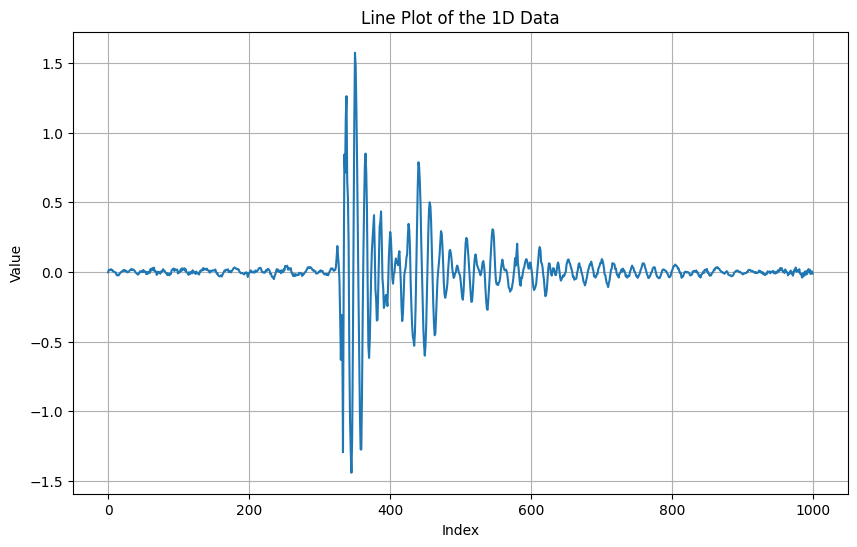

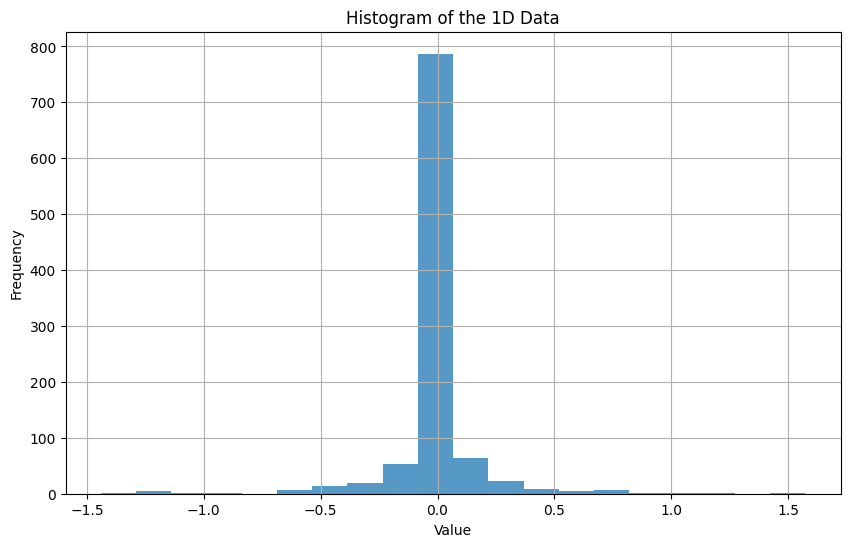

In [43]:
# Generate some sample data
# import numpy as np
data = np.random.normal(loc=0, scale=1, size=1000)  # 1000 samples from a normal distribution
index = 700
data = train_dataset[index][0][0]
label = train_dataset[index][1]
print(f"class: {label.item()}")
# # Visualize the data as a line plot
visualize_1d_data(data, plot_type='line')

# # Visualize the data distribution as a histogram
visualize_1d_data(data, plot_type='histogram')

In [44]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(self.expansion*planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
class mod_resnet(nn.Module):
    def __init__(self, block, layers, channel_num_list, num_classes=1000, input_channel=3):
        super(mod_resnet, self).__init__()
        self.in_channels = channel_num_list[0]
        self.conv1 = nn.Conv1d(input_channel, channel_num_list[0], kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(channel_num_list[0])
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        # self.layer1 = self._make_layer(block, channel_num_list[1], layers[0])
        # self.layer2 = self._make_layer(block, channel_num_list[2], layers[1], stride=2)
        # self.layer3 = self._make_layer(block, channel_num_list[3], layers[2], stride=2)
        # self.layer4 = self._make_layer(block, channel_num_list[4], layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d((1,))
        self.fc = nn.Linear(channel_num_list[-1] * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        # x = self.layer1(x)
        # x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [52]:
model_list = {
    "VibrationCNN" : lambda: VibrationCNN(),
    "mod_res":lambda: mod_resnet(BasicBlock, [0, 0,0,0], channel_num_list=[2, 16, 16, 32, 2], num_classes=3, input_channel=1),
}
model_name = "VibrationCNN"
model_name = "mod_res"
loaders = base_func.get_dataloaders(train_dataset, 0.6, 0.5, 16)
phases = ['train','val']
base_func.train(model_list, model_name, loaders, phases)

--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [494, 488, 574, 473, 246]
--------- INDEX shuffled ---------

Total number of samples: 750 datapoints
Number of train samples: 29 batches/ 450 datapoints
Number of val samples: 10 batches/ 150 datapoints
Number of test samples: 10 batches/ 150 datapoints

Training model: mod_res
Total parameters: 27
Learning rate=0.001


100%|██████████| 29/29 [00:00<00:00, 725.79it/s]


Epoch [1/25], phase: train, samples: 450, Loss: 0.0747, Top-1 Accuracy: 34.67%


100%|██████████| 10/10 [00:00<00:00, 1000.36it/s]


Epoch [1/25], phase: val, samples: 150, Loss: 0.0759, Top-1 Accuracy: 30.67%


100%|██████████| 29/29 [00:00<00:00, 579.85it/s]


Epoch [2/25], phase: train, samples: 450, Loss: 0.0733, Top-1 Accuracy: 34.67%


100%|██████████| 10/10 [00:00<00:00, 1000.41it/s]


Epoch [2/25], phase: val, samples: 150, Loss: 0.0758, Top-1 Accuracy: 30.67%


100%|██████████| 29/29 [00:00<00:00, 483.45it/s]


Epoch [3/25], phase: train, samples: 450, Loss: 0.0720, Top-1 Accuracy: 34.67%


100%|██████████| 10/10 [00:00<00:00, 998.45it/s]


Epoch [3/25], phase: val, samples: 150, Loss: 0.0745, Top-1 Accuracy: 30.67%


100%|██████████| 29/29 [00:00<00:00, 580.20it/s]


Epoch [4/25], phase: train, samples: 450, Loss: 0.0708, Top-1 Accuracy: 34.67%


100%|██████████| 10/10 [00:00<?, ?it/s]


Epoch [4/25], phase: val, samples: 150, Loss: 0.0735, Top-1 Accuracy: 30.67%


100%|██████████| 29/29 [00:00<00:00, 580.56it/s]


Epoch [5/25], phase: train, samples: 450, Loss: 0.0699, Top-1 Accuracy: 34.67%


100%|██████████| 10/10 [00:00<00:00, 997.65it/s]


Epoch [5/25], phase: val, samples: 150, Loss: 0.0726, Top-1 Accuracy: 30.67%


100%|██████████| 29/29 [00:00<00:00, 580.17it/s]


Epoch [6/25], phase: train, samples: 450, Loss: 0.0690, Top-1 Accuracy: 34.67%


100%|██████████| 10/10 [00:00<00:00, 1002.15it/s]


Epoch [6/25], phase: val, samples: 150, Loss: 0.0719, Top-1 Accuracy: 30.67%


100%|██████████| 29/29 [00:00<00:00, 580.30it/s]


Epoch [7/25], phase: train, samples: 450, Loss: 0.0682, Top-1 Accuracy: 34.67%


100%|██████████| 10/10 [00:00<00:00, 997.60it/s]


Epoch [7/25], phase: val, samples: 150, Loss: 0.0711, Top-1 Accuracy: 30.67%


100%|██████████| 29/29 [00:00<00:00, 483.95it/s]


Epoch [8/25], phase: train, samples: 450, Loss: 0.0675, Top-1 Accuracy: 34.67%


100%|██████████| 10/10 [00:00<00:00, 994.43it/s]


Epoch [8/25], phase: val, samples: 150, Loss: 0.0704, Top-1 Accuracy: 30.67%


100%|██████████| 29/29 [00:00<00:00, 580.88it/s]


Epoch [9/25], phase: train, samples: 450, Loss: 0.0668, Top-1 Accuracy: 34.67%


100%|██████████| 10/10 [00:00<?, ?it/s]


Epoch [9/25], phase: val, samples: 150, Loss: 0.0698, Top-1 Accuracy: 30.67%


100%|██████████| 29/29 [00:00<00:00, 580.60it/s]


Epoch [10/25], phase: train, samples: 450, Loss: 0.0661, Top-1 Accuracy: 34.67%


100%|██████████| 10/10 [00:00<00:00, 1000.48it/s]


Epoch [10/25], phase: val, samples: 150, Loss: 0.0691, Top-1 Accuracy: 30.67%


100%|██████████| 29/29 [00:00<00:00, 483.31it/s]


Epoch [11/25], phase: train, samples: 450, Loss: 0.0655, Top-1 Accuracy: 34.67%


100%|██████████| 10/10 [00:00<00:00, 1000.26it/s]


Epoch [11/25], phase: val, samples: 150, Loss: 0.0685, Top-1 Accuracy: 30.67%


100%|██████████| 29/29 [00:00<00:00, 580.43it/s]


Epoch [12/25], phase: train, samples: 450, Loss: 0.0649, Top-1 Accuracy: 34.67%


100%|██████████| 10/10 [00:00<00:00, 1000.50it/s]


Epoch [12/25], phase: val, samples: 150, Loss: 0.0678, Top-1 Accuracy: 30.67%


100%|██████████| 29/29 [00:00<00:00, 483.55it/s]


Epoch [13/25], phase: train, samples: 450, Loss: 0.0642, Top-1 Accuracy: 35.11%


100%|██████████| 10/10 [00:00<00:00, 1002.75it/s]


Epoch [13/25], phase: val, samples: 150, Loss: 0.0671, Top-1 Accuracy: 31.33%


100%|██████████| 29/29 [00:00<00:00, 580.20it/s]


Epoch [14/25], phase: train, samples: 450, Loss: 0.0636, Top-1 Accuracy: 36.00%


100%|██████████| 10/10 [00:00<?, ?it/s]


Epoch [14/25], phase: val, samples: 150, Loss: 0.0665, Top-1 Accuracy: 34.00%


100%|██████████| 29/29 [00:00<00:00, 580.12it/s]


Epoch [15/25], phase: train, samples: 450, Loss: 0.0630, Top-1 Accuracy: 39.78%


100%|██████████| 10/10 [00:00<00:00, 1003.52it/s]


Epoch [15/25], phase: val, samples: 150, Loss: 0.0658, Top-1 Accuracy: 39.33%


100%|██████████| 29/29 [00:00<00:00, 579.91it/s]


Epoch [16/25], phase: train, samples: 450, Loss: 0.0622, Top-1 Accuracy: 46.67%


100%|██████████| 10/10 [00:00<00:00, 1001.77it/s]


Epoch [16/25], phase: val, samples: 150, Loss: 0.0651, Top-1 Accuracy: 50.67%


100%|██████████| 29/29 [00:00<00:00, 483.49it/s]


Epoch [17/25], phase: train, samples: 450, Loss: 0.0615, Top-1 Accuracy: 54.22%


100%|██████████| 10/10 [00:00<00:00, 999.10it/s]


Epoch [17/25], phase: val, samples: 150, Loss: 0.0643, Top-1 Accuracy: 52.67%


100%|██████████| 29/29 [00:00<00:00, 483.38it/s]


Epoch [18/25], phase: train, samples: 450, Loss: 0.0609, Top-1 Accuracy: 58.22%


100%|██████████| 10/10 [00:00<00:00, 1002.32it/s]


Epoch [18/25], phase: val, samples: 150, Loss: 0.0637, Top-1 Accuracy: 54.00%


100%|██████████| 29/29 [00:00<00:00, 580.03it/s]


Epoch [19/25], phase: train, samples: 450, Loss: 0.0602, Top-1 Accuracy: 60.00%


100%|██████████| 10/10 [00:00<00:00, 1003.42it/s]


Epoch [19/25], phase: val, samples: 150, Loss: 0.0630, Top-1 Accuracy: 55.33%


100%|██████████| 29/29 [00:00<00:00, 580.49it/s]


Epoch [20/25], phase: train, samples: 450, Loss: 0.0596, Top-1 Accuracy: 61.78%


100%|██████████| 10/10 [00:00<00:00, 995.07it/s]


Epoch [20/25], phase: val, samples: 150, Loss: 0.0623, Top-1 Accuracy: 56.67%


100%|██████████| 29/29 [00:00<00:00, 483.49it/s]


Epoch [21/25], phase: train, samples: 450, Loss: 0.0590, Top-1 Accuracy: 62.22%


100%|██████████| 10/10 [00:00<00:00, 1001.72it/s]


Epoch [21/25], phase: val, samples: 150, Loss: 0.0616, Top-1 Accuracy: 59.33%


100%|██████████| 29/29 [00:00<00:00, 580.02it/s]


Epoch [22/25], phase: train, samples: 450, Loss: 0.0584, Top-1 Accuracy: 70.00%


100%|██████████| 10/10 [00:00<00:00, 1002.18it/s]


Epoch [22/25], phase: val, samples: 150, Loss: 0.0610, Top-1 Accuracy: 92.67%


100%|██████████| 29/29 [00:00<00:00, 483.28it/s]


Epoch [23/25], phase: train, samples: 450, Loss: 0.0578, Top-1 Accuracy: 79.33%


100%|██████████| 10/10 [00:00<00:00, 1001.46it/s]


Epoch [23/25], phase: val, samples: 150, Loss: 0.0603, Top-1 Accuracy: 94.67%


100%|██████████| 29/29 [00:00<00:00, 483.51it/s]


Epoch [24/25], phase: train, samples: 450, Loss: 0.0572, Top-1 Accuracy: 85.78%


100%|██████████| 10/10 [00:00<00:00, 999.36it/s]


Epoch [24/25], phase: val, samples: 150, Loss: 0.0597, Top-1 Accuracy: 95.33%


100%|██████████| 29/29 [00:00<00:00, 580.48it/s]


Epoch [25/25], phase: train, samples: 450, Loss: 0.0566, Top-1 Accuracy: 90.44%


100%|██████████| 10/10 [00:00<00:00, 1000.33it/s]

Epoch [25/25], phase: val, samples: 150, Loss: 0.0590, Top-1 Accuracy: 95.33%
Elapsed time: 1.649454116821289 seconds


mod_resnet(
  (conv1): Conv1d(1, 2, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool1d(output_size=(1,))
  (fc): Linear(in_features=2, out_features=3, bias=True)
)